# Analyse the PAIBB

This notebook analyses and visualizes the results for **Percentage of Attentions Inside Bounding Boxes** (PAIBB) metric

In [1]:
import os
import re
import sys
import json
import random
random.seed(42)
from typing import Optional, Any
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

package_root = os.path.dirname(os.getcwd())
sys.path.insert(0, package_root)

import torch
torch.manual_seed(42)

import numpy as np
np.random.seed(42)

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
import matplotlib.patches as patches
import seaborn as sns

sns.set(font_scale=1.4)
sns.set_style("whitegrid", {
    "grid.linestyle": 'dashed',
    "axes.edgecolor": '#475569',
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial',
        'Droid Sans',
        'sans-serif'
    ],
})
%matplotlib inline

coco_path = Path(package_root) / "data" / "COCO" / "val2017"

# Load coco annotation
with open(coco_path.parent / "annotations" / "instances_val2017.json") as f:
    coco_annos = json.load(f)

In [2]:
annotations = coco_annos['annotations']
def get_annos_for_img(img_id: int) -> Any:
    annos = filter(lambda x: x['image_id'] == img_id, annotations)
    return list(annos)

In [3]:
metric_dir = Path(package_root) / "outputs" / "metrics" / "paibb"

data = []
fpath = metric_dir / "paibb_sparsemax.txt"
with open(fpath, "r") as f:
    for line in f:
        # Replace single quotes with double quotes for JSONEncoder to work
        line = line.replace("\'", "\"")
        item = json.loads(line)
        data.append(item)

print("# items", len(data))
print(data[0])

# items 36335
{'img_id': 139, 'query_id': 2, 'gt_id': 16, 'gt_area': 120.56837463378906, 'paibb': 0.08124540746212006}


In [4]:
df = pd.DataFrame(data)
df.count()

img_id      36335
query_id    36335
gt_id       36335
gt_area     36335
paibb       36335
dtype: int64

**Compute the Average PAIBB**

In [5]:
df[['paibb']].mean()

paibb    0.416217
dtype: float64

**Plotting the histogram of ground-truth areas**

Text(0, 0.5, 'Number of boxes')

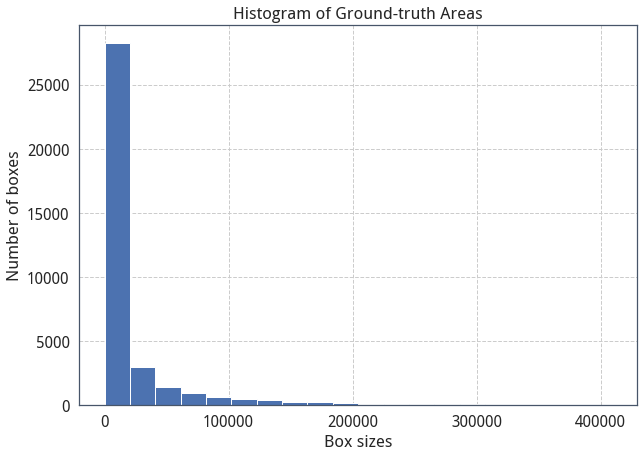

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
df.hist(column='gt_area', bins=20, ax=ax)
ax.set_title("Histogram of Ground-truth Areas")
ax.set_xlabel("Box sizes")
ax.set_ylabel("Number of boxes")

In [7]:
print("gt_area.max = ", df[['gt_area']].max())
print("gt_area.min = ", df[['gt_area']].min())

gt_area.max =  gt_area    409094.40625
dtype: float64
gt_area.min =  gt_area    2.513361
dtype: float64


In [8]:
df[(df.paibb == 0) & (df.gt_area > 5000) & (df.index > 5000)]

,img_id,query_id,gt_id,gt_area,paibb
10516,167486,33,9,53429.609375,0.0
14494,228214,39,1,5673.894043,0.0
14511,228436,49,26,16674.332031,0.0
34941,560178,19,2,9531.477539,0.0


In [9]:
df[df.img_id == 82807]

,img_id,query_id,gt_id,gt_area,paibb
5121,82807,20,3,17043.367188,0.533417
5122,82807,55,2,118559.960938,0.745740
5123,82807,56,1,107022.500000,0.589716
5124,82807,82,0,159362.437500,0.546493


### Inspect for image `82807`

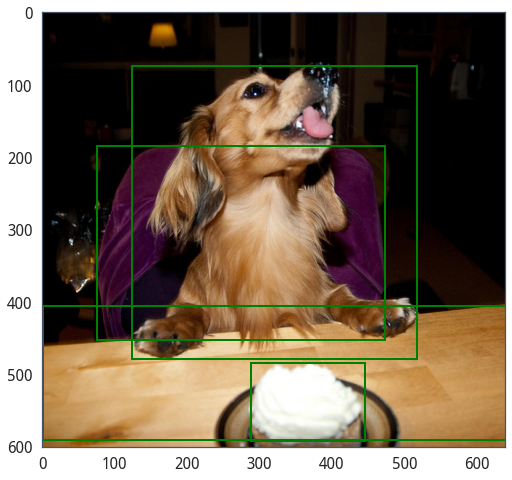

In [10]:
img_id = 82807
img = Image.open(coco_path / (f"{img_id}".rjust(12, '0') + '.jpg'))

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img)
ax.grid(False)

img_annos = get_annos_for_img(img_id)
for img_anno in img_annos:
    x, y, w, h = img_anno['bbox']
    ax.add_patch(patches.Rectangle((x, y), w, h, fill=False, edgecolor='green', lw=2))

**Load attention for sparsemax model for this image**

torch.Size([1, 100, 675])


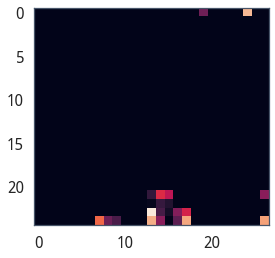

In [16]:
import torch.nn.functional as F

res = torch.load(Path(package_root) / "temp" / ("sparsemax_attns_" + f"{img_id}".rjust(12, '0') + '.pt'), map_location="cpu")
print(res['attentions'].shape)
# print(res['image_id'])
# print(res['orig_size'])
attns_t = res['attentions'].view(1, 100, 25, 27).squeeze(0)

plt.imshow(attns_t[20].detach().cpu())
plt.grid(False)

torch.Size([100, 25, 27])
82807
tensor([601, 640])


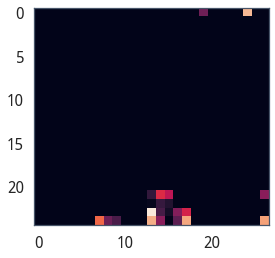

In [17]:
res = torch.load(Path(package_root) / "outputs" / "attentions" / "sparsemax" / (f"{img_id}".rjust(12, '0') + '.pt'), map_location="cpu")
print(res['attentions'].shape)
print(res['image_id'])
print(res['orig_size'])

plt.imshow(res['attentions'][20].detach().cpu())
plt.grid(False)

In [18]:
res['attentions'].shape[-2:]

torch.Size([25, 27])

In [19]:
img_h, img_w = res['orig_size'].unbind(-1)

h, w = res['attentions'].shape[-2:]
# B, num_queries, K = res['attentions'].shape
# assert K == w * h

attentions = F.interpolate(res['attentions'].unsqueeze(0), (img_h, img_w), mode='bilinear')
attentions.shape

torch.Size([1, 100, 601, 640])

In [20]:
attns = attentions.squeeze(0)
attns.shape

torch.Size([100, 601, 640])

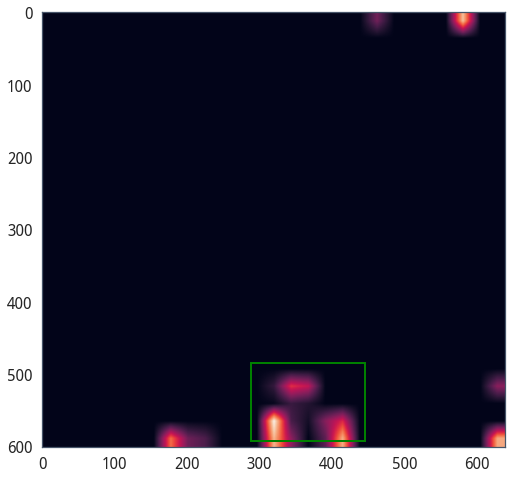

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.imshow(attns[20].detach().cpu().numpy())
ax.grid(False)

bbox = img_annos[3]['bbox']
x, y, w, h = bbox
ax.add_patch(patches.Rectangle((x, y), w, h, fill=False, edgecolor='green', lw=2))

In [22]:
print(x, y, w, h)

287.37 483.98 157.59 108.15


In [23]:
xmin, xmax = int(x), int(x + w)
ymin, ymax = int(y), int(y + h)
print(f"x={x}, y={y}, w={w}, h={h}")
print(f"xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")

x=287.37, y=483.98, w=157.59, h=108.15
xmin=287, ymin=483, xmax=444, ymax=592


In [26]:
attn_inside = attns[20][int(ymin):int(ymax), int(xmin):int(xmax)]
attn_inside.sum() / attns[20].sum() * 100

tensor(53.3417)

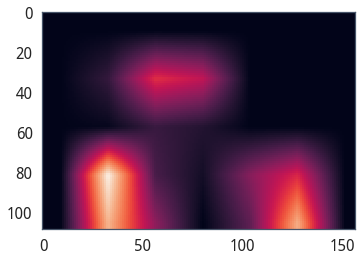

In [27]:
plt.imshow(attn_inside)
plt.grid(False)